<a href="https://colab.research.google.com/github/tsutsumi-ozro/BERT_inp/blob/main/BERT4FirstTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was created based on [this](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.0 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 36.4 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppd #why ppd?
import warnings
warnings.filterwarnings('ignore')

import dataset

In [3]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [4]:
df.head() #labeled data

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [5]:
batch_1 = df[:2000]

In [6]:
batch_1[1].value_counts()

1    1041
0     959
Name: 1, dtype: int64

Load BERT model

In [7]:
model_class, tokenizer_class, pretrained_weights = (ppd.DistilBertModel, ppd.DistilBertTokenizer, 'distilbert-base-uncased')

In [8]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preparing the dataset

In [9]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [11]:
batch_1[0][:5]

0    a stirring , funny and finally transporting re...
1    apparently reassembled from the cutting room f...
2    they presume their audience wo n't sit still f...
3    this is a visually stunning rumination on love...
4    jonathan parker 's bartleby should have been t...
Name: 0, dtype: object

In [10]:
tokenized #101=[CLS]

0       [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1       [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2       [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3       [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4       [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
                              ...                        
1995    [101, 2205, 20857, 1998, 11865, 16643, 2135, 5...
1996    [101, 2009, 2515, 1050, 1005, 1056, 2147, 2004...
1997    [101, 2023, 2028, 8704, 2005, 1996, 11848, 199...
1998    [101, 1999, 1996, 2171, 1997, 2019, 9382, 1898...
1999    [101, 1996, 3185, 2003, 25757, 2011, 1037, 244...
Name: 0, Length: 2000, dtype: object

In [14]:
tokenized.values[0]

[101,
 1037,
 18385,
 1010,
 6057,
 1998,
 2633,
 18276,
 2128,
 16603,
 1997,
 5053,
 1998,
 1996,
 6841,
 1998,
 5687,
 5469,
 3152,
 102]

In [12]:
max_len = 0
for i in tokenized.values:
    if len(i)>max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #max_lenとの差分、末尾に0を追加

In [15]:
np.array(padded).shape

(2000, 59)

In [17]:
#paddingされているもの(0)を0, それ以外を1
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

Let's Deep Learning

In [19]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

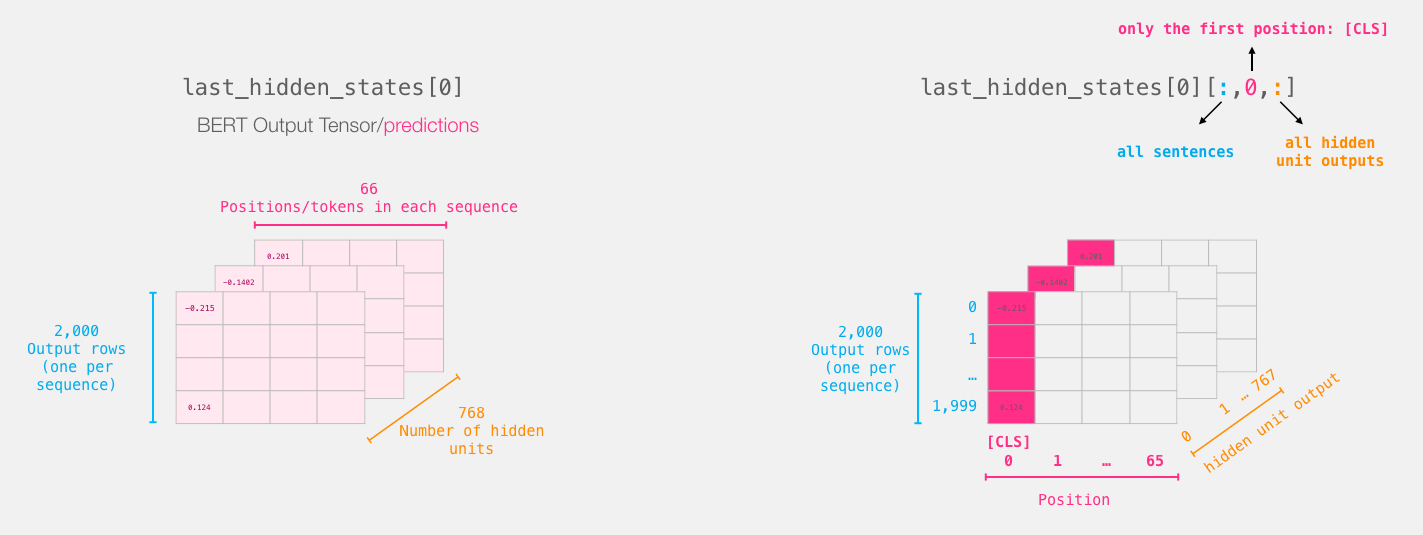

In [20]:
features = last_hidden_states[0][:, 0, :].numpy()

In [28]:
labels = batch_1[1]

In [29]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [30]:
# Grid Search
# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

In [31]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [32]:
lr_clf.score(test_features, test_labels)

0.82

BERT でやってみる

In [33]:
model_class, tokenizer_class, pretrained_weights = (ppd.BertModel, ppd.BertTokenizer, 'bert-base-uncased')

In [34]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [37]:
max_len = 0
for i in tokenized.values:
    if len(i)>max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [38]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [39]:
features = last_hidden_states[0][:, 0, :].numpy()
labels = batch_1[1]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.836

ちょっとしか上がらんな！